In [1]:
from pathlib import Path
import PIL
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os

from loguru import logger as log
log.remove()
log.add(sys.stdout, level="ERROR")


from ufish.api import UFish
from cellpose import models

from utils import (
    get_signal_masks, assign_spots, segment_cells, extract_cells,
    plot_figs, plot_all_rois, plot_on_img
)
from skimage.measure import regionprops, label

In [2]:
# Cancer pathology samples : PML/RARA
data_dir = "./PML-RARA-Fusion"

if not os.path.exists(data_dir):
    raise FileNotFoundError(f"The directory {data_dir} does not exist.")

sample = os.listdir(data_dir)
print("Sample dirs:", sample)

img_paths = {}

for s in sample:
    sample_path = os.path.join(data_dir, s)
    if os.path.isdir(sample_path):
        for path in Path(sample_path).glob("*.TIF"):
            img_paths[path.stem] = path

print(img_paths)

images = {
    name: np.array(PIL.Image.open(path))
    for name, path in img_paths.items()
}


Sample dirs: ['F2409132A', 'F2410254A']
{'F2409132A.1': WindowsPath('PML-RARA-Fusion/F2409132A/F2409132A.1.TIF'), 'F2409132A.268': WindowsPath('PML-RARA-Fusion/F2409132A/F2409132A.268.TIF'), 'F2410254A.1': WindowsPath('PML-RARA-Fusion/F2410254A/F2410254A.1.TIF'), 'F2410254A.299': WindowsPath('PML-RARA-Fusion/F2410254A/F2410254A.299.TIF')}


In [3]:
# initialize cellpose model
cp = models.Cellpose(gpu=False, model_type="nuclei")

# initialize ufish model
uf = UFish()
uf.load_weights("./v1.0.1-DNAFISH_model.onnx")

In [6]:
images['F2409132A.1'].shape

(3000, 4096, 3)

In [22]:
# split each image into 4 ROIs
img_rois = {}
for name, img in images.items():
    h, w = img.shape[:2]
    roi_h, roi_w = h//2, w//2
    _rois = [
        img[i*roi_h:(i+1)*roi_h, j*roi_w:(j+1)*roi_w]
        for i in range(2) for j in range(2)
    ]
    for i, roi in enumerate(_rois):
        img_rois[name + f"_ROI.{i}"] = roi

In [13]:
def filter_cell_by_prop(
        prop,
        img_size,
        area_threshold=1000,
        axis_ratio_threshold=0.5,
        border_threshold=1
        ):
    close_to_edge = False
    if prop.coords[:, 0].min() <= border_threshold or \
            prop.coords[:, 0].max() >= img_size[0] - border_threshold or \
            prop.coords[:, 1].min() <= border_threshold or \
            prop.coords[:, 1].max() >= img_size[1] - border_threshold:
        close_to_edge = True
    if close_to_edge:
        return False
    if prop.area < area_threshold:
        return False
    axis_ratio = prop.minor_axis_length / prop.major_axis_length
    if axis_ratio < axis_ratio_threshold:
        return False
    return True

def filter_cell_by_signals(
        signals, num_thresh_per_channel=3, num_thresh=5):
    count = 0
    for _, signal in signals.items():
        count += signal.shape[0]
        if signal.shape[0] > num_thresh_per_channel:
            return False
    if count < 2:
        return False
    if count > num_thresh:
        return False
    return True

In [14]:
from skimage.morphology import dilation, disk

# Define pipeline
def pipeline(img, signal_channels=[0, 1]):
    print("---------- Begin pipeline ----------")
    print(f"Image shape: {img.shape}")
    print("Step 1: segment cells")
    mask = segment_cells(cp, img)
    print(f"Number of cells: {mask.max()}")
    mask = dilation(mask, disk(3))

    print("Step 2: extract ROIs")
    cell_rois, cell_masks, cell_props = extract_cells(
        img, mask, target_size=128)
    
    print("Step 3: call signals and assign spots for each cell")
    table = []
    cell_signals = []
    new_cell_rois = []
    new_cell_masks = []
    new_cell_props = []
    filtered_by_prop = []
    filtered_by_signals = []
    for c, cell_roi in enumerate(cell_rois):
        cell_prop = cell_props[c]
        if not filter_cell_by_prop(cell_prop, mask.shape):
            filtered_by_prop.append(c)
            continue
        signal_mask_merge, signal_masks_sub = get_signal_masks(
            uf, cell_roi, signal_channels, quantile=5,
            mask_dilation_size=4, hard_threshold=30
        )
        signals = {}
        for ch in signal_channels:
            signals[f"ch{ch+1}"] = []
        name = "+".join([f"ch{ch+1}" for ch in signal_channels])
        signals[name] = []
        for i, ch in enumerate(signal_channels):
            single_ch = regionprops(label(signal_masks_sub[i]))
            spots = np.array([cc.centroid for cc in single_ch])
            signals[f"ch{ch+1}"] = spots
        merged = regionprops(label(signal_mask_merge))
        spots = np.array([cc.centroid for cc in merged])
        name = "+".join([f"ch{ch+1}" for ch in signal_channels])
        signals[name] = spots

        if not filter_cell_by_signals(signals):
            filtered_by_signals.append(c)
            continue

        assigns = {}
        for name, spots in signals.items():
            try:
                assigns[name] = assign_spots(spots, cell_masks[c], 30)
            except Exception:
                assigns[name] = []

        df = {
            key: sum(value) for key, value in assigns.items()
            if isinstance(value, np.ndarray)
        }
        df["cell_id"] = f'{c+1}'
        last_key = list(df.keys())[-1]
        last_value = df.pop(last_key)
        df = {last_key: last_value, **df}
        table.append(df)
        cell_signals.append(signals)
        new_cell_rois.append(cell_roi)
        new_cell_masks.append(cell_masks[c])
        new_cell_props.append(cell_props[c])
    print(f"Number of cells filtered by properties: {len(filtered_by_prop)}")
    print(f"Number of cells filtered by signals: {len(filtered_by_signals)}")
    return pd.DataFrame(table).fillna(0), new_cell_rois, new_cell_masks, cell_signals, new_cell_props


In [16]:
from shutil import rmtree
import os
main_dir = "PML-RARA_results"
os.makedirs(main_dir, exist_ok=True)
for name, img in img_rois.items():
    print(name)
    res_dir = f"./{main_dir}/{name}"
    if os.path.exists(res_dir):
        rmtree(f"./{res_dir}")
    os.mkdir(f"./{res_dir}")

    if name.startswith("Trisomy"):
        signal_channels=[0]
    else:
        signal_channels=[0, 1]
    #img = img[:1000, :1000, :]  # crop image for testing
    table, rois, masks, signals, props = pipeline(img, signal_channels)
    plot_figs(rois, masks, signals, res_dir)

    fig = plot_all_rois(rois, masks, signals, colors={"ch1": "hotpink", "ch2": "lime", "ch1+ch2": "yellow"})
    fig.savefig(f"{res_dir}/{name}_all_cells.pdf")
    plt.close(fig)
    table.to_csv(f"{res_dir}/{name}_results.csv", index=False)

    fig = plot_on_img(img, props)
    fig.savefig(f"{res_dir}/{name}_cell_id.pdf")
    plt.close(fig)


F2409132A.1_ROI.0
---------- Begin pipeline ----------
Image shape: (1500, 2048, 3)
Step 1: segment cells
Number of cells: 142
Step 2: extract ROIs
Step 3: call signals and assign spots for each cell
Number of cells filtered by properties: 29
Number of cells filtered by signals: 22
F2409132A.1_ROI.1
---------- Begin pipeline ----------
Image shape: (1500, 2048, 3)
Step 1: segment cells
Number of cells: 110
Step 2: extract ROIs
Step 3: call signals and assign spots for each cell
Number of cells filtered by properties: 26
Number of cells filtered by signals: 22
F2409132A.1_ROI.2
---------- Begin pipeline ----------
Image shape: (1500, 2048, 3)
Step 1: segment cells
Number of cells: 125
Step 2: extract ROIs
Step 3: call signals and assign spots for each cell
Number of cells filtered by properties: 19
Number of cells filtered by signals: 21
F2409132A.1_ROI.3
---------- Begin pipeline ----------
Image shape: (1500, 2048, 3)
Step 1: segment cells
Number of cells: 136
Step 2: extract ROIs
Ste

In [24]:
print(img_rois.keys())

dict_keys(['F2409132A.1_ROI.0', 'F2409132A.1_ROI.1', 'F2409132A.1_ROI.2', 'F2409132A.1_ROI.3', 'F2409132A.268_ROI.0', 'F2409132A.268_ROI.1', 'F2409132A.268_ROI.2', 'F2409132A.268_ROI.3', 'F2410254A.1_ROI.0', 'F2410254A.1_ROI.1', 'F2410254A.1_ROI.2', 'F2410254A.1_ROI.3', 'F2410254A.299_ROI.0', 'F2410254A.299_ROI.1', 'F2410254A.299_ROI.2', 'F2410254A.299_ROI.3'])


In [25]:
# Results statistics

res_dir = "PML-RARA_results"

csv_paths = {}

for s in img_rois.keys():
    sample_path = os.path.join(res_dir, s)
    if os.path.isdir(sample_path):
        for path in Path(sample_path).glob("*.csv"):
            csv_paths[path.stem] = path
csv_paths

{'F2409132A.1_ROI.0_results': WindowsPath('PML-RARA_results/F2409132A.1_ROI.0/F2409132A.1_ROI.0_results.csv'),
 'F2409132A.1_ROI.1_results': WindowsPath('PML-RARA_results/F2409132A.1_ROI.1/F2409132A.1_ROI.1_results.csv'),
 'F2409132A.1_ROI.2_results': WindowsPath('PML-RARA_results/F2409132A.1_ROI.2/F2409132A.1_ROI.2_results.csv'),
 'F2409132A.1_ROI.3_results': WindowsPath('PML-RARA_results/F2409132A.1_ROI.3/F2409132A.1_ROI.3_results.csv'),
 'F2409132A.268_ROI.0_results': WindowsPath('PML-RARA_results/F2409132A.268_ROI.0/F2409132A.268_ROI.0_results.csv'),
 'F2409132A.268_ROI.1_results': WindowsPath('PML-RARA_results/F2409132A.268_ROI.1/F2409132A.268_ROI.1_results.csv'),
 'F2409132A.268_ROI.2_results': WindowsPath('PML-RARA_results/F2409132A.268_ROI.2/F2409132A.268_ROI.2_results.csv'),
 'F2409132A.268_ROI.3_results': WindowsPath('PML-RARA_results/F2409132A.268_ROI.3/F2409132A.268_ROI.3_results.csv'),
 'F2410254A.1_ROI.0_results': WindowsPath('PML-RARA_results/F2410254A.1_ROI.0/F2410254A.

In [46]:
def cal_rate(file_path):

    data = pd.read_csv(file_path, header=0)

    # abnorbal 
    abnormal_cells = data[(data['ch1+ch2'] ==2)&(data['ch1']==1)&(data['ch2']==1)]
    # normal 
    normal_cells = data[(data['ch1+ch2'] ==0)&(data['ch1']==2)&(data['ch2']==2)]
    
    # positive rate
    positive_rate = len(abnormal_cells) / (len(normal_cells)+len(abnormal_cells))
    
    return positive_rate, abnormal_cells.shape[0], normal_cells.shape[0]

In [47]:
import pandas as pd

# calculate positive rates
rows = []
for sample, csv_path in csv_paths.items():
    positive_rate, n_an, n_n = cal_rate(csv_path)
    print(f"Sample {sample} positive rate: {positive_rate:.2f}")
    group = "before" if sample.startswith("F2409132A") else "after"
    rows.append([sample, positive_rate, group, n_an, n_n])

df = pd.DataFrame(rows, columns=["sample", "positive_rate", "group", "N_abnormal", "N_normal"])

Sample F2409132A.1_ROI.0_results positive rate: 0.24
Sample F2409132A.1_ROI.1_results positive rate: 0.23
Sample F2409132A.1_ROI.2_results positive rate: 0.04
Sample F2409132A.1_ROI.3_results positive rate: 0.17
Sample F2409132A.268_ROI.0_results positive rate: 0.12
Sample F2409132A.268_ROI.1_results positive rate: 0.25
Sample F2409132A.268_ROI.2_results positive rate: 0.33
Sample F2409132A.268_ROI.3_results positive rate: 0.24
Sample F2410254A.1_ROI.0_results positive rate: 0.75
Sample F2410254A.1_ROI.1_results positive rate: 0.86
Sample F2410254A.1_ROI.2_results positive rate: 0.82
Sample F2410254A.1_ROI.3_results positive rate: 0.75
Sample F2410254A.299_ROI.0_results positive rate: 0.60
Sample F2410254A.299_ROI.1_results positive rate: 0.86
Sample F2410254A.299_ROI.2_results positive rate: 0.60
Sample F2410254A.299_ROI.3_results positive rate: 1.00


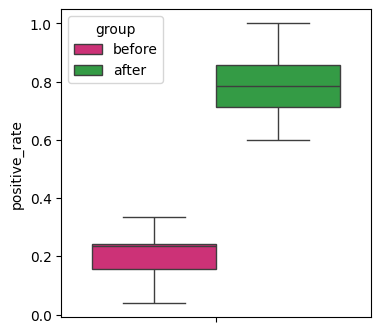

In [56]:
from seaborn import boxplot
fig, ax = plt.subplots(figsize=(4, 4))
boxplot(data=df, hue="group", y="positive_rate", palette=['#e61874', '#23ac39'])
plt.savefig("./PML-RARA_results/positive_rate_compare.pdf")

In [53]:
from scipy.stats import ttest_ind

before = df[df["group"] == "before"]["positive_rate"]
after = df[df["group"] == "after"]["positive_rate"]

ttest_ind(before, after)

TtestResult(statistic=-10.023251824906506, pvalue=9.076422483490514e-08, df=14.0)

In [54]:
np.mean(before), np.mean(after)

(0.20255265567765568, 0.7790584415584416)